In [ ]:
import pandas as pd
import numpy as np
import random
import operator
import matplotlib.pyplot as plt
import io
import PIL
import math

#Amazon Men

In [ ]:
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonMenWithImgPartitioned.npy

--2021-12-03 00:53:34--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonMenWithImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonMenWithImgPartitioned.npy [following]
--2021-12-03 00:53:35--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonMenWithImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2276159058 (2.1G)
Saving to: ‘AmazonMenWithImgPartitioned.npy’

AmazonMenWithImgPar 100%[===================>]   2.12G  11.6MB/s    in 2m 12s  

2021-12-03 00:55:47 (16.4 MB/s) - ‘AmazonMenWithImgPartitioned.npy’ saved [2276159058/2276159058]



In [ ]:
dataset_name = "AmazonMenWithImgPartitioned.npy"

#Hyper-prameters
K = 5#100 # Latent dimensionality
lambda1 = 0.001 # Weight decay
lambda2 = 1.0 # Regularizer for theta_u
learning_rate = 1e-4
training_epoch = 2 #20
batch_size = 4000 #128
dropout = 0.5 # Dropout, probability to keep units
numldprocess=4 # multi-threading for loading images


dataset = np.load(dataset_name,allow_pickle=True,encoding='bytes')

[user_train, user_validation, user_test, Item, usernum, itemnum] = dataset

In [ ]:
!curl -L -o "u2.train" "https://drive.google.com/uc?export=download&id=1SOW8fl6SY6cKcdzPyEO_9zOMg8Okd6Vj"

!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1Hx8dXsl1oTRotAnGfjb5NskSq0mOl9g2"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    984      0 --:--:-- --:--:-- --:--:--   984
100  308k  100  308k    0     0   491k      0 --:--:-- --:--:-- --:--:--  491k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1545      0 --:--:-- --:--:-- --:--:--  1545
100 90831  100 90831    0     0   205k      0 --:--:-- --:--:-- --:--:--  205k


## Most Popular

In [ ]:
df_train = pd.read_csv('u2.train',
                         sep=',',
                         names=['userid', 'itemid', 'rating'],
                         header=0)
df_train.head()

,userid,itemid,rating
0,5.0,37.0,4.0
1,5.0,39.0,4.0
2,32.0,229.0,5.0
3,32.0,238.0,5.0
4,32.0,241.0,4.0


In [ ]:
df_test = pd.read_csv('u2.test',
                         sep=',',
                         names=['userid', 'itemid', 'rating'],
                         header=0)
df_test.head()

,userid,itemid,rating
0,5.0,36.0,5.0
1,32.0,244.0,5.0
2,34.0,258.0,5.0
3,36.0,277.0,5.0
4,53.0,381.0,5.0


Contamos las veces que aparece cada item en train

In [ ]:
apariciones_men = {}

for item in df_train['itemid']:
  if item not in apariciones_men.keys():
    apariciones_men[item]=1
  else:
    apariciones_men[item]+=1 

mp_ordenado_men = dict( sorted(apariciones_men.items(), key=operator.itemgetter(1),reverse=True))

TOP-10 Most-Popular

In [ ]:
top_10= list(mp_ordenado_men.keys())[:10]

top_10

[3094.0, 240.0, 2288.0, 6184.0, 2263.0, 409.0, 6258.0, 1291.0, 2743.0, 1843.0]

In [ ]:
def plot_images(ids):    
    plt.close()
    n = len(ids)
    nrows = math.ceil(n/5)
    ncols = min(n, 5)
    plt.figure(1, (20, 5 * nrows))

    for i, _id in enumerate(ids):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_yticks([])
        ax.set_xticks([])
        img =Item[ids[i]][b'imgs']
        image_bytes = io.BytesIO(img)
        img_ = PIL.Image.open(image_bytes)
        img_
        if img is None:
            ax.set_title('%d) id = %d not found' % (i, _id))
        else:
            ax.set_title('%d) item_id = %d' % (i, _id))
            ax.imshow(img_, interpolation="nearest")
    plt.show()

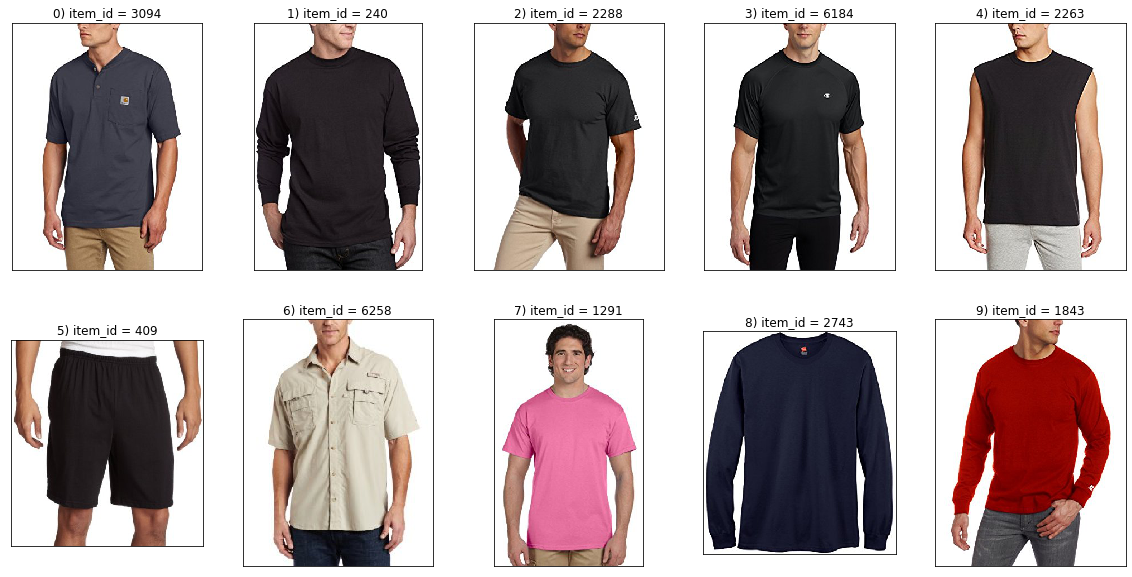

In [ ]:
plot_images(top_10)

Se calcula el AUC

In [ ]:
items = list(df_train['itemid'].unique())

def AUC(user_test, df_train ,df_test, dic):
  """
  para cada usuario cuenta cuantos items de una muestra aleatoria tiene rating menor a 
  al rating del item consumido en test
  """
  ans=0
  cc=0

  for user in user_test:
      item_test= df_test[df_test['userid'] == user]['itemid'].values[0]

      if item_test in items:
        cc+=1
        no_considerar= set(list(df_train[df_train['userid']==user]['itemid'])+ [item_test]) 
        count=0
        tmpans=0

        for j in random.sample(items,int(50*(len(no_considerar)-1))): #sample
        #for j in items:
            if j in no_considerar: continue
            if dic[item_test] > dic[j]:
              tmpans+=1
            count +=1

        tmpans/=float(count)
        ans+=tmpans
  
  ans/=float(cc)
  return ans



def simple_test(df_test, df_train, dic): #primera función que llama
  """
  Calcula AUC para todos los usuarios comparada con el elemento que quedo en el test set
  dict_tov: test o validacion
  """

  test_users = list(df_train['userid'].unique())     #ACTUALIZADO 
  batch_result = AUC(test_users, df_train, df_test, dic)

  return batch_result

In [ ]:
simple_test(df_test, df_train, mp_ordenado)

0.7616808408914638

### Distribución de items más populares 

In [ ]:
id_test = df_test['itemid'].unique()

restringido = df_train[df_train['itemid'].isin(id_test)]

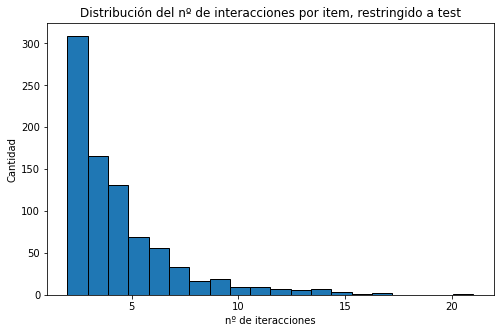

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(restringido["itemid"].value_counts(), bins=20, range= [2,21], ec='k')
plt.xlabel('nº de iteracciones')
plt.ylabel('Cantidad')
plt.title("Distribución del nº de interacciones por item, restringido a test")
plt.locator_params(axis='x', integer=True)
plt.show()

## Random 

In [ ]:
dic_puntuaciones_random = {}

for item in df_train['itemid'].unique():
  dic_puntuaciones_random[item] = np.random.uniform(-1,1,1)[0]

Se calcula el AUC

In [ ]:
simple_test(df_test, df_train, dic_puntuaciones_random)

0.4915828001466746

Algunas recomendaciones random

In [ ]:
rand = random.sample(list(dic_puntuaciones_random.keys()),10)

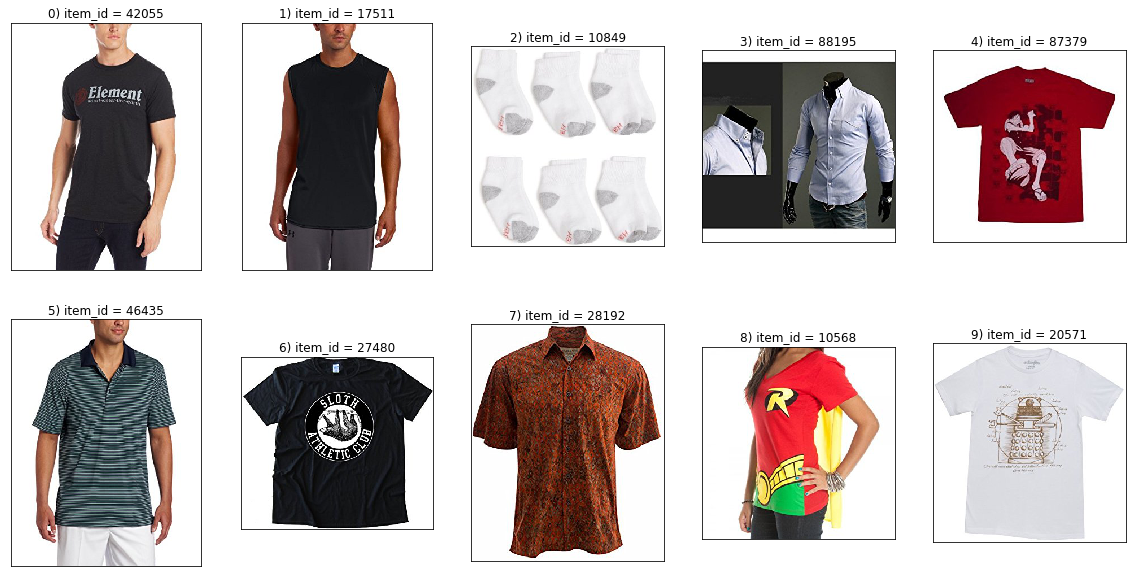

In [ ]:
plot_images(rand)

# Amazon Women

In [ ]:
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy 

--2021-12-03 01:30:29--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy [following]
--2021-12-03 01:30:30--  https://cseweb.ucsd.edu//~wckang/DVBPR/AmazonWomenWithImgPartitioned.npy
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6644545540 (6.2G)
Saving to: ‘AmazonWomenWithImgPartitioned.npy.1’

AmazonWomenWithImgP 100%[===================>]   6.19G  15.6MB/s    in 5m 56s  

2021-12-03 01:36:26 (17.8 MB/s) - ‘AmazonWomenWithImgPartitioned.npy.1’ saved [6644545540/6644545540]



In [ ]:
dataset_name = "AmazonWomenWithImgPartitioned.npy"

#Hyper-prameters
K = 5#100 # Latent dimensionality
lambda1 = 0.001 # Weight decay
lambda2 = 1.0 # Regularizer for theta_u
learning_rate = 1e-4
training_epoch = 2 #20
batch_size = 4000 #128
dropout = 0.5 # Dropout, probability to keep units
numldprocess=4 # multi-threading for loading images


dataset = np.load(dataset_name,allow_pickle=True,encoding='bytes')

[user_train, user_validation, user_test, Item, usernum, itemnum] = dataset

In [ ]:
!curl -L -o "u2.train" "https://drive.google.com/uc?export=download&id=1IAEiU5WaKQeysSjP4ox2c0ml4SIu6MYT"

!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1SJMnXhk9LVaWAcdeaQyEent2yU6P2h3d"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    815      0 --:--:-- --:--:-- --:--:--   813
100  278k  100  278k    0     0   379k      0 --:--:-- --:--:-- --:--:--  379k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1111      0 --:--:-- --:--:-- --:--:--  1108
100 76064  100 76064    0     0   122k      0 --:--:-- --:--:-- --:--:--  122k


## Most Popular

In [ ]:
df_train = pd.read_csv('u2.train',
                         sep=',',
                         names=['userid', 'itemid', 'rating'],
                         header=0)
df_train.head()

,userid,itemid,rating
0,24.0,230.0,5.0
1,24.0,232.0,5.0
2,24.0,231.0,5.0
3,25.0,238.0,5.0
4,25.0,239.0,5.0


In [ ]:
df_test = pd.read_csv('u2.test',
                         sep=',',
                         names=['userid', 'itemid', 'rating'],
                         header=0)
df_test.head()

,userid,itemid,rating
0,24.0,229.0,5.0
1,25.0,250.0,5.0
2,34.0,303.0,4.0
3,43.0,375.0,5.0
4,74.0,621.0,4.0


In [ ]:
apariciones_women = {}

for item in df_train['itemid']:
  if item not in apariciones_women.keys():
    apariciones_women[item]=1
  else:
    apariciones_women[item]+=1 

mp_ordenado_women = dict( sorted(apariciones_women.items(), key=operator.itemgetter(1),reverse=True))

In [ ]:
top_10= list(mp_ordenado_women.keys())[:10]

top_10

[3409.0, 1247.0, 2908.0, 3018.0, 10693.0, 6383.0, 5379.0, 777.0, 906.0, 6181.0]

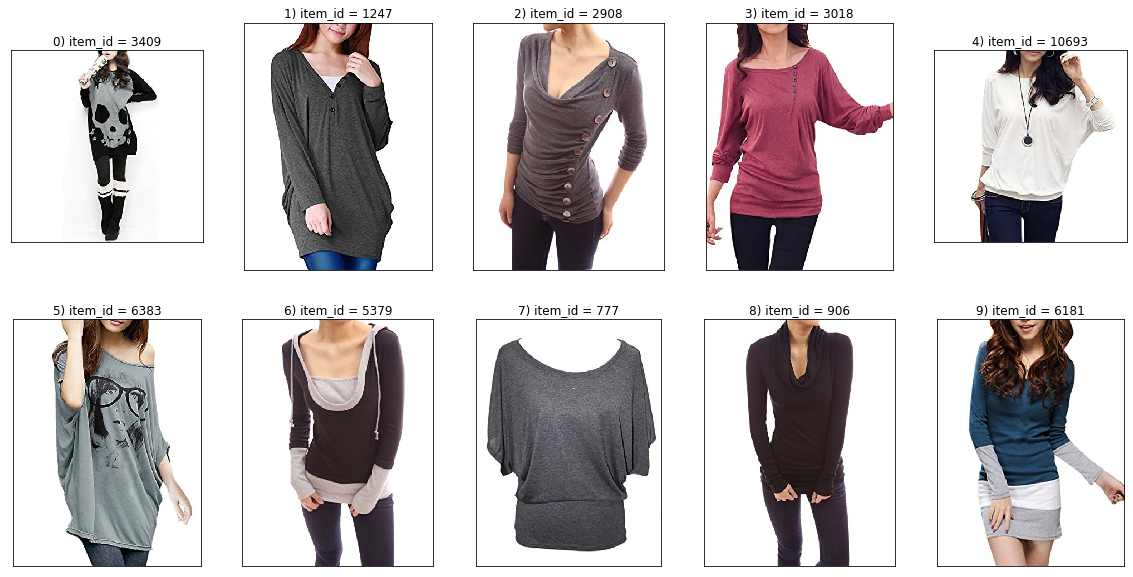

In [ ]:
plot_images(top_10)

Se calcula AUC

In [ ]:
items = list(df_train['itemid'].unique())

def AUC(user_test, df_train ,df_test, dic):
  """
  para cada usuario cuenta cuantos items de una muestra aleatoria tiene rating menor a 
  al rating del item consumido en test
  """
  ans=0
  cc=0

  for user in user_test:
      item_test= df_test[df_test['userid'] == user]['itemid'].values[0]

      if item_test in items:
        cc+=1
        no_considerar= set(list(df_train[df_train['userid']==user]['itemid'])+ [item_test]) 
        count=0
        tmpans=0

        for j in random.sample(items,int(50*(len(no_considerar)-1))): #sample
        #for j in items:
            if j in no_considerar: continue
            if dic[item_test] > dic[j]:
              tmpans+=1
            count +=1

        tmpans/=float(count)
        ans+=tmpans
  
  ans/=float(cc)
  return ans



def simple_test(df_test, df_train, dic): #primera función que llama
  """
  Calcula AUC para todos los usuarios comparada con el elemento que quedo en el test set
  dict_tov: test o validacion
  """

  test_users = list(df_train['userid'].unique())     #ACTUALIZADO 
  batch_result = AUC(test_users, df_train, df_test, dic)

  return batch_result

In [ ]:
simple_test(df_test, df_train, mp_ordenado_women)

0.8140572825375398

### Distribución de items más populares 

In [ ]:
id_test = df_test['itemid'].unique()

restringido = df_train[df_train['itemid'].isin(id_test)]

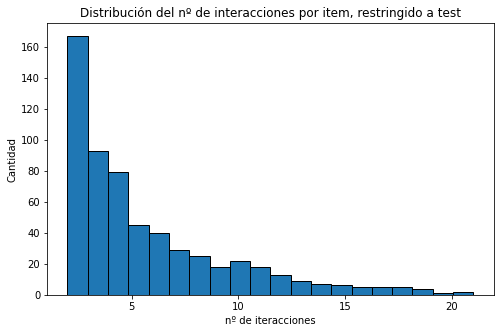

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(restringido["itemid"].value_counts(), bins=20, range= [2,21], ec='k')
plt.xlabel('nº de iteracciones')
plt.ylabel('Cantidad')
plt.title("Distribución del nº de interacciones por item, restringido a test")
plt.locator_params(axis='x', integer=True)
plt.show()

## Random

In [ ]:
dic_puntuaciones_random_women = {}

for item in df_train['itemid'].unique():
  dic_puntuaciones_random_women[item] = np.random.uniform(-1,1,1)[0]

In [ ]:
rand = random.sample(list(dic_puntuaciones_random_women.keys()),10)

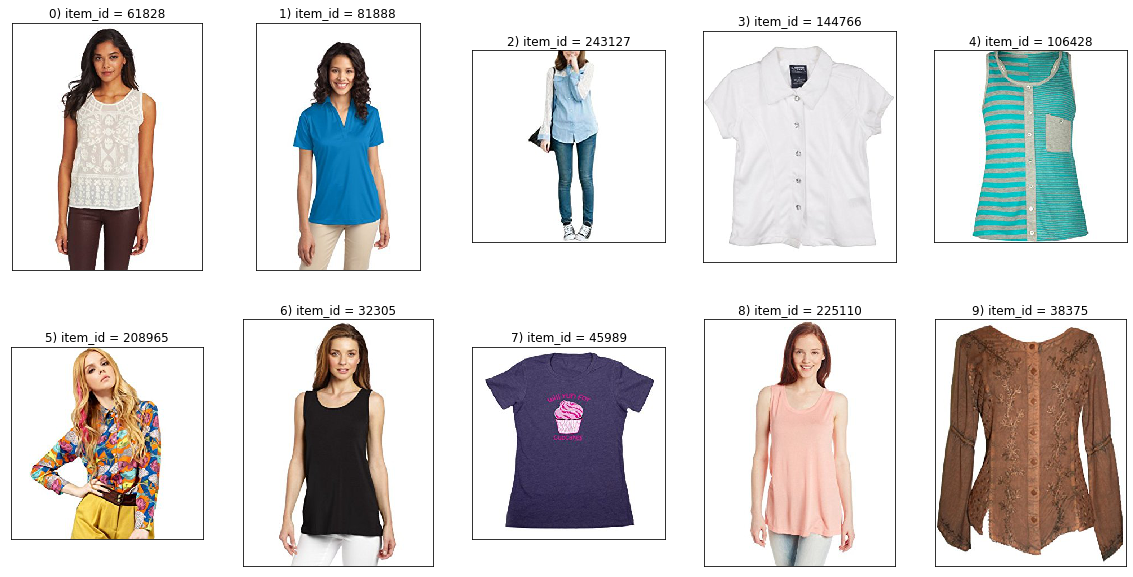

In [ ]:
plot_images(rand)

Se calcula AUC

In [ ]:
simple_test(df_test, df_train, dic_puntuaciones_random_women)

0.4970420385807639